In [1]:
%load_ext autoreload
%autoreload 2

# Genetic Algorithm approach for solving the problem of Project 2.

## Overview of Project 2:
- The goal is to build a model that combines two advantages: has high accuracy and is parsimonious, i.e., is based on a small number of variables.
- We have 5000 historical training data. Each client is described with 500 variables (variables are anonymized). Your task is to build a model that predicts which customers in the test set took advantage of the offer.
    - That means that the number of variables in the model should be small, but the model should have high accuracy.
    - We need a good balance between the number of variables and the accuracy of the model, that is why we need the algorithm that can adapt the number of variables in the model to the specific minimization problem.
- Additionally, you should indicate the variables that were used to build the model. The effectiveness of your prediction will be assessed as follows:
    - For each designated customer who actually took advantage of the offer, the company will pay you €10.
    - For each variable used, you must pay €200 (the company bears the cost of obtaining information related to individual variables).
        - Our goal is to maximize the profit, i.e., to maximize the difference between the revenue from the correct prediction and the cost of the variables used in the model.
        - The profit is calculated as follows: `profit = 10 * (number of correctly predicted customers) - 200 * (number of variables used)`
        - **This will be the criterion for the effectiveness of the model, instead of it being the accuracy of the model.**

## Genetic Algorithm proposal:

- **Genetic Algorithm** is a search heuristic that is inspired by Charles Darwin’s theory of natural evolution. This algorithm reflects the process of natural selection where the fittest individuals are selected for reproduction in order to produce offspring of the next generation.
- The algorithm starts with a population of solutions (represented by chromosomes) and applies the principle of natural selection to evolve the population of solutions.
    - For our case, chromosomes will represent the variables used in the model.
    - Given the size of the problem, we will first manually select the best 50 variables using the best performing feature selection method.
    - The genetic algorithm will then be used to select the best subset of these 50 variables.
    - We will also choose the model "manually" during the selection of the best 50 variables.
- The genetic algorithm will be implemented as follows:
    - The fitness function will be the profit function.
    - The genetic operators will be mutation and crossover.
    - The selection operator will be the tournament selection.
    - The stopping criterion will be the number of generations or the number of generations without improvement.
    - The initial population will be generated randomly.
    - The mutation probability will be set to 0.1, and the crossover probability will be set to 0.9. 


## Steps:

### 1. Load the data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

X = pd.read_table('./data/x_train.txt', header=None, delimiter=' ')
y = pd.read_table('./data/y_train.txt', header=None)

X_test = pd.read_table('./data/x_test.txt', header=None, delimiter=' ')

X.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,-2.619773,-2.619533,-1.199350,-1.083335,-1.000910,-0.366967,-2.164037,-1.210001,-0.658311,-1.489539,...,10.849925,10.343346,10.717519,7.709295,5.894554,12.416573,6.765269,16.243907,7.209524,8.082021
1,-1.415579,-1.782544,-2.880270,-1.958863,1.159968,0.273030,-1.628728,-0.175813,-0.916857,-0.570166,...,11.489417,5.195818,3.494627,5.529154,10.517576,15.697333,11.324938,12.187670,12.283861,5.032285
2,-2.745092,-1.382945,-1.626015,-1.282560,-0.663146,0.052349,-2.403322,-0.765073,-0.394354,-0.806624,...,13.934934,9.267515,4.705604,6.642557,14.658934,8.130767,7.194487,11.939354,11.653620,5.942778
3,0.618998,0.455364,-0.115081,0.649040,-0.862207,2.308504,0.526114,-1.094852,1.088656,-0.481210,...,12.021328,3.852231,11.059702,7.527268,7.253120,9.791136,6.089743,10.752796,5.778888,10.366363
4,-0.070694,-0.550509,-0.565556,-0.693065,-0.573089,-0.395862,0.003170,-0.981609,-0.505775,-0.758430,...,7.537788,11.229665,11.318915,6.622256,12.557882,5.520360,5.397359,13.152269,10.684779,9.816471


### 2. Data preprocessing

We will perform following steps for data preprocessing:
- Check for missing values - we will filter out the columns with missing values.
- Check for cross-correlation between the variables - we will filter out the variables with high correlation.
- Check for the variance of the variables - we will filter out the variables using Variance Inflation Factor (VIF) with a threshold of 10.
- Check for the distribution of the variables - we will normalize the variables using StandardScaler.
- Check for the class imbalance - we will use SMOTE for oversampling the minority class.

In [3]:
from utils import cleanup_dataset_remove_features_vif, cleanup_dataset_remove_features_correlation, cleanup_dataset_apply_standard_scaler

In [4]:
# Check for missing values

missing_values = X.isnull().sum()
print(f'Missing values in the dataset: {missing_values.sum()}')

Missing values in the dataset: 0


There are no missing values in the dataset.

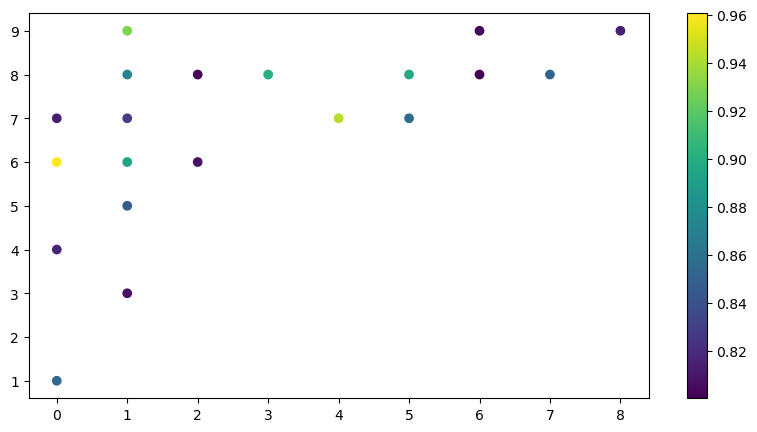

In [5]:
# Check for cross-correlation between the variables

correlation_matrix = X.corr().abs()
# Plot the correlation matrix, since there is 5000 variables,
# we will plot only the variables that have correlation greater than 0.8, 
# preserving the indices of the variables

upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
upper = upper.stack().reset_index()
upper.columns = ['var1', 'var2', 'correlation']
upper = upper[upper['correlation'] > 0.8]

plt.figure(figsize=(10, 5))
plt.scatter(upper['var1'], upper['var2'], c=upper['correlation'], cmap='viridis')
plt.colorbar()
plt.show()

In [6]:
# Remove the variables with high correlation

correlated_features = cleanup_dataset_remove_features_correlation(X, threshold=0.8)
print(f'Number of correlated features: {len(correlated_features)}, correlated features: {correlated_features}')

X = X.drop(correlated_features, axis=1)
X_test = X_test.drop(correlated_features, axis=1)

Number of correlated features: 10, correlated features: [1, 0, 4, 6, 7, 3, 5, 8, 9, 2]



The variables with high correlation have been removed - 10 variables out of 500 - it is a good result.

In [7]:
# Check for the variance of the variables

variance_features = cleanup_dataset_remove_features_vif(X, threshold=10)
print(f'Number of variance features: {len(variance_features)}, variance features: {variance_features}')

X = X.drop(variance_features, axis=1)
X_test = X_test.drop(variance_features, axis=1)

Calculating VIF:   0%|          | 1/490 [00:01<10:38,  1.31s/it]

KeyboardInterrupt: 

There are no variables with high variance inflation factor (VIF) - it is a good result.

In [8]:
# Check for the distribution of the variables

X = cleanup_dataset_apply_standard_scaler(X)
X_test = cleanup_dataset_apply_standard_scaler(X_test)

The dataset is now cleaned and normalized.

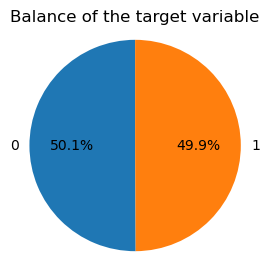

In [9]:
# Check for the class imbalance

target_counts = y.value_counts()

# Plot a pie chart
plt.figure(figsize=(3, 3))
plt.pie(target_counts, labels=['0', '1'], autopct='%1.1f%%', startangle=90)
plt.title('Balance of the target variable')
plt.axis('equal')
plt.show()

The dataset is balanced.

### 3. Feature selection

We will use following methods for feature selection and follow the best performing method for the genetic algorithm:

- Recursive Feature Elimination (RFE) with Logistic Regression, Random Forest, Gradient Boosting Classifier and Support Vector Machine.
- Random Forest Classifier
- Dimensionality Reduction using PCA
- Perceptron Feature Selection

For every method, we will run the method multiple times to stabilize the results. 
Then as an additional step, we will find the common features among the methods.

This will give us a set of 100 features that will be used as input for the genetic algorithm given the performance of the feature selection methods.

In [25]:
%pip install skrebate mrmr_selection

Note: you may need to restart the kernel to use updated packages.


In [11]:
selected_features_per_method = {}

In [21]:
from collections import Counter
from utils import feature_selectors
from tqdm import tqdm

iters = 50
for method_key, method in feature_selectors.items():
    if method_key in selected_features_per_method:
        continue
    
    print(f'Applying method: {method_key}')
    
    # To stabilize the results, we will run the method multiple times
    tqdm._instances.clear()
    bar = tqdm(total=iters)
    
    all_selected_features = []
    for iter in range(iters):
        selected_features = method(X, y.values.ravel(), random_state=iter)
        all_selected_features.append(selected_features)
        bar.update(1)
    
    bar.close()
    
    # Find the features that are common among all the iterations
    common_features_counter = Counter(np.concatenate(all_selected_features))
    common_features = [feature for feature, count in common_features_counter.items() if count > 0.9 * iters]
    common_features = pd.Index(common_features)
    
    selected_features_per_method[method_key] = common_features
    print(f'Number of selected features: {len(common_features)}, selected features: {common_features}')


In [17]:
selected_features_per_method

{'mrmr': Index([105,  64, 131, 136, 100, 102,  24, 103, 104, 359, 101,  29, 266,  57,
         39, 241, 351, 155, 335, 442],
       dtype='int64'),
 'surf': Index([105, 102, 101, 321, 100, 289, 283, 374, 254, 311,
        ...
        378, 228, 354, 394, 232, 332, 299, 279, 356, 382],
       dtype='int64', length=490),
 'forest': Index([100, 101, 102, 103, 104, 105, 403], dtype='int64'),
 'xgb': Index([100, 101, 102, 103, 104, 105], dtype='int64')}

In [32]:
# Find common features among the methods
most_common_features = Counter(np.concatenate(list(selected_features_per_method.values())))

common_features = [feature for feature, count in most_common_features.items() if count >= 2]
print(f'Number of common features: {len(common_features)}, common features: {common_features}')
selected_features_per_method['common_features'] = list(pd.Index(common_features))

Number of common features: 21, common features: [105.0, 64.0, 131.0, 136.0, 100.0, 102.0, 24.0, 103.0, 104.0, 359.0, 101.0, 29.0, 266.0, 57.0, 39.0, 241.0, 351.0, 155.0, 335.0, 442.0, 403.0]


The amount of common features from the feature selection methods is 26. It is a good number of features that are common between all feature selectors, and we can add these features to the genetic algorithm as they are considered the most important for every method.

In [33]:
# Save the selected features
import pickle

with open('./genetic_algorithm_selected_features_per_method.pkl', 'wb') as f:
    pickle.dump(selected_features_per_method, f)

In [34]:
model_results_per_selection_method = {}

In [35]:
from utils import model_appliers
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

test_train_split = 0.8
iters = 10

for selection_method_key, selected_features in selected_features_per_method.items():
    for model_key, model in model_appliers.items():
        print(f'Applying model: {model_key} with selection method: {selection_method_key}')
        results = []
        for iter in range(iters):
            X_train, X_test, y_train, y_test = train_test_split(X[selected_features], y, test_size=test_train_split, random_state=0)
            y_pred = model(X_train, y_train.values.ravel(), X_test, random_state=iter)
            accuracy = accuracy_score(y_test, y_pred)
            results.append(accuracy)
            
        if model_key not in model_results_per_selection_method:
            model_results_per_selection_method[model_key] = {}
        model_results_per_selection_method[model_key][selection_method_key] = np.array(results)

Applying model: random_forest with selection method: mrmr
Applying model: gradient_boosting_classifier with selection method: mrmr
Applying model: mlp with selection method: mrmr
Applying model: sgd with selection method: mrmr
Applying model: random_forest with selection method: surf
Applying model: gradient_boosting_classifier with selection method: surf
Applying model: mlp with selection method: surf
Applying model: sgd with selection method: surf
Applying model: random_forest with selection method: forest
Applying model: gradient_boosting_classifier with selection method: forest
Applying model: mlp with selection method: forest
Applying model: sgd with selection method: forest
Applying model: random_forest with selection method: xgb
Applying model: gradient_boosting_classifier with selection method: xgb
Applying model: mlp with selection method: xgb
Applying model: sgd with selection method: xgb
Applying model: random_forest with selection method: common_features
Applying model: gra

In [36]:
# Apply model on all features

for model_key, model in model_appliers.items():
    print(f'Applying model: {model_key} with all features')
    results = []
    for iter in range(iters):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_train_split, random_state=0)
        y_pred = model(X_train, y_train.values.ravel(), X_test, random_state=iter)
        accuracy = accuracy_score(y_test, y_pred)
        results.append(accuracy)

    if model_key not in model_results_per_selection_method:
        model_results_per_selection_method[model_key] = {}
    model_results_per_selection_method[model_key]['all_features'] = np.array(results)

Applying model: random_forest with all features
Applying model: gradient_boosting_classifier with all features
Applying model: mlp with all features
Applying model: sgd with all features


#### Results

We will plot the results for every model and selection method to see which combination gives the best results.
The results are based on the accuracy of the model and then on the selection of the features.

From the model results we can see that Random Forest Classifier gives the ideal results on every selection method.
Also, the Gradient Boosting Classifier gives very good results on every selection method.

Common Features (13 features only) gives us also very good results with Random Forest Classifier and Gradient Boosting Classifier - even when compared to the best performing feature selection methods that use 50 features.

Every 

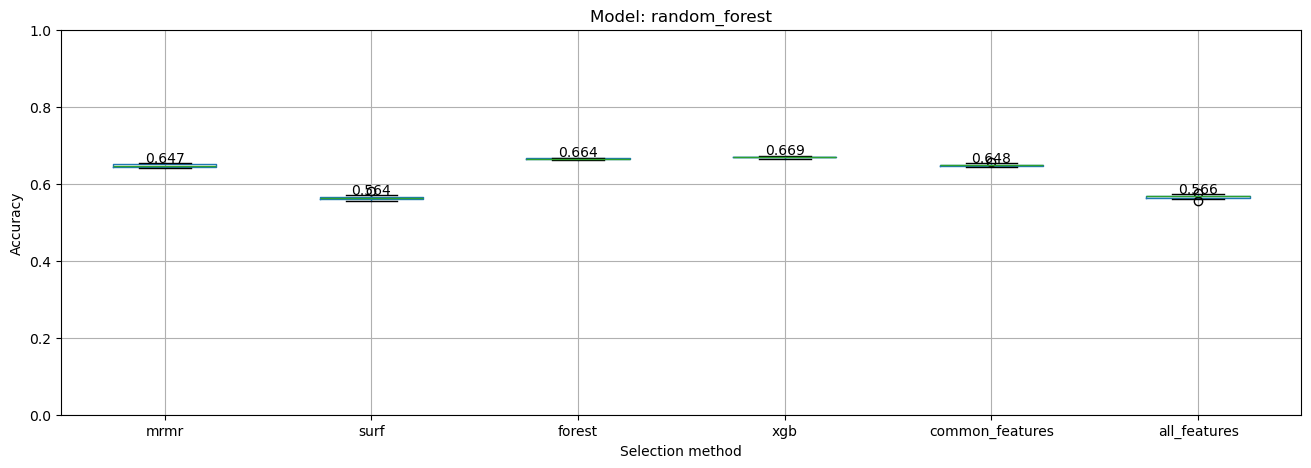

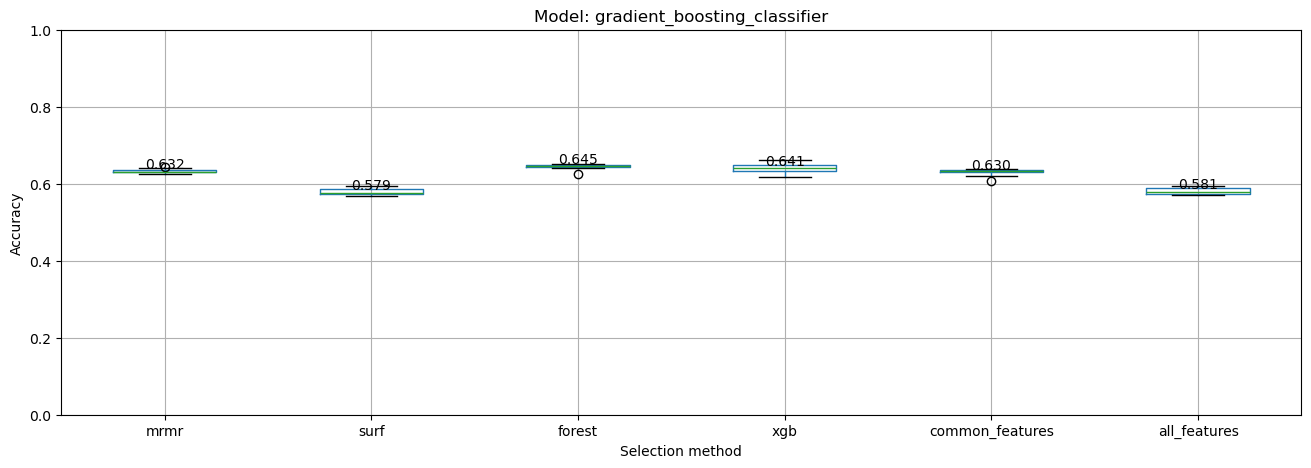

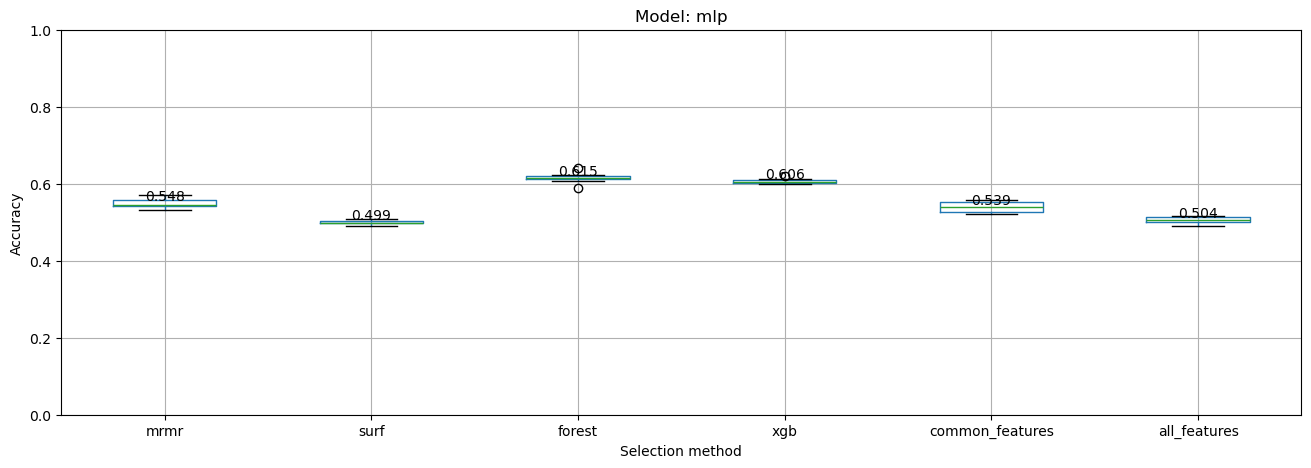

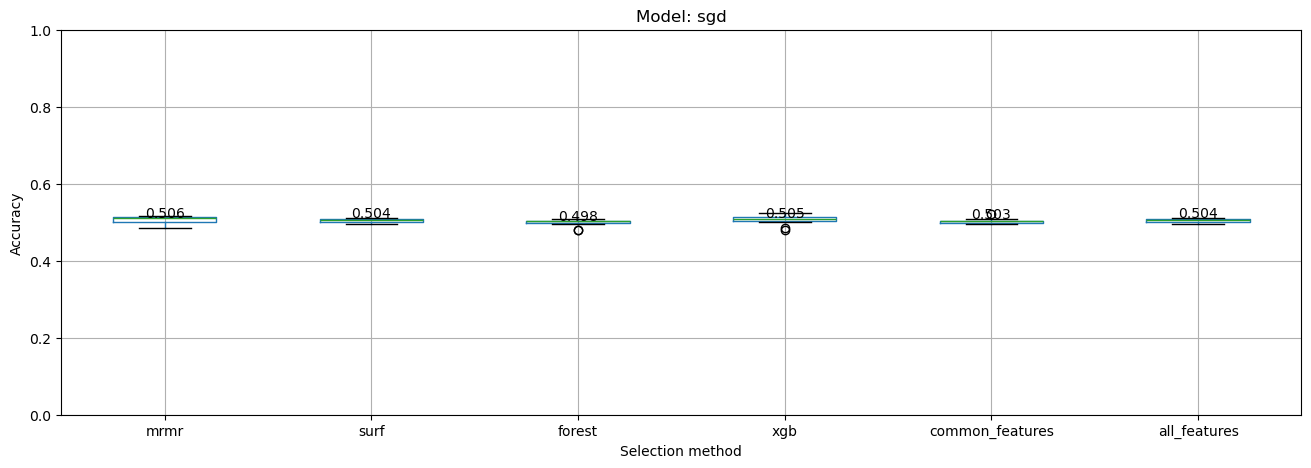

In [37]:
for model_key, model_results in model_results_per_selection_method.items():
    plt.figure(figsize=(16, 5))
    plt.title(f'Model: {model_key}')
    plt.xlabel('Selection method')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)

    # Show values for each bar on boxplot
    model_results_df = pd.DataFrame(model_results)
    model_results_df.boxplot()
    
    for i, model_result in zip(range(1, len(model_results) + 1), model_results.values()):
        model_result_mean = model_result.mean()
        plt.text(i, model_result_mean, f'{model_result_mean:.3f}', ha='center', va='bottom')